# Contents

- [Reiteration of Problem statement](#Reiteration-of-Problem-statement)
- [Methodology](#Methodology)
- [Preprocessing](#Preprocessing)
- [Model with Base Features](#Model-with-Base-Features)
- [Polynomial Features](#Polynomial-Features)
- [SMOTE](#SMOTE)
- [Model Evaluaton](#Model-Evaluaton)
- [Cost-Benefit Analysis of Spraying](#Cost-Benefit-Analysis-of-Spraying)
- [Conclusions](#Conclusions)

# Reiteration of Problem Statement

In view of the recent epidemic in Windy City of Chicago state affecting the state population, we aim to build a classifier model to make predictions on the possibility of West Nile Virus occurence on various locations of interest, which could be used to aid the deployment of pesticides in the fight for public health and safety. 
The model would be build using collected data related to mosquito population from the surveillance and control system setup by Deparment of Public Health. 

In addition, a cost-benefit analysis would be conducted on the cost benefits for the use of pesticides as a response in managing the epidemic. 

# Methodology

The methodology involved in the modelling process can be described as follows:

**1) Preprocessing and direct modelling**
 - Converting the data into suitable format for modelling
 - Applying baseline classifier to set baseline metric for comparison with of other models
 - Applying pearson's correlation with 3 different cutoff points for correlation (> 0.01, > 0.05 and > 0.1) to identify correlated features while selecting useful features for direct modelling. Models considered are listed in point 4
 
**2) Feature Expansion**
 - Generate polynomial and interaction features to increase the number of features involving cross terms with a degree 2 to prevent excessive feature expansion and scaling the data subsequently
 
**3) Feature Selection**
 - A) Recursive Feature Selection to select ideal features for modelling
 - B) Principal Component Analysis to reduce dimensionality of features by using principal component features generated from the data features
 
**4) Modelling, hyperparameter tuning and best model selection**

- Models considered with hyperparameters dictated by gridsearch
 - A) **Support Vector Classifier**: Effective in high dimensional spaces. Uses a subset of training points in the decision function.
 - B) **Logistic Regression**: Effective in binary classification.
 - C) **Gradient boost**: Produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. Uses gradient descent algorithm.
 - D) **Xg boost**: Similar to gradient boost, but it uses a more regularized model formalization to control over-fitting.
 - E) **Random Forest**: Constructs decision trees at training time and outputting the class that is the mode of the classes.
 - F) **Extra Trees**: Similar to Random Forest. However, the splits of the trees in the Random Forest are deterministic. It is random for extratrees.

- Subsequently finetune the parameters, and select the best model based on ROC-AUC score, precision and recall.

In [15]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.decomposition import PCA

In [35]:
from xgboost import XGBClassifier

In [3]:
train = pd.read_csv('../assets/train_combined.csv', parse_dates=['date'])
test = pd.read_csv('../assets/test_combined.csv', parse_dates=['date'])

## Preprocessing

(just standard scaler first, later section then poly)

In [21]:
# Define X,y
y = train['wnvpresent']
X = train.drop(columns=['wnvpresent','date'])

# Train/test split our data.
X_train, X_holdout, y_train, y_holdout = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    test_size = 0.30,
                                                    random_state = 42)

# Instantiate our StandardScaler.
ss = StandardScaler()
# Scale X_train.
X_train_sc = ss.fit_transform(X_train)
# Scale X_test.
X_holdout_sc = ss.transform(X_holdout)

## Model with Base Features

..

## Polynomial Features

We will try out doing polynomial features on our training data to see if we can improve our final model.
Due to notebook structure, we will comment out the code below that is used to run polynomial features.

\# Poly by power of 2.  
pf = PolynomialFeatures(degree=2)  
\# Fit and transform our X data using Polynomial Features.  
X_new = pf.fit_transform(X)  

### PCA

1) We perform PCA to do feature extraction on our models, selecting the best features to be used.

**Two assumptions that PCA makes:**

 -- A. **Linearity:** PCA detects and controls for linear relationships, so we assume that the data does not hold nonlinear relationships (or that we don't care about these nonlinear relationships).
    - We are using our covariance matrix to determine important "directions," which is a measure of the linear relationship between observations!
    
 -- B. **Large variances define importance:** If data is spread in a direction, that direction is important! If there is little spread in a direction, that direction is not very important.

2) GridsearchCV etc to get best results. Compare best model for each feature set, choose best of best

3) Refit best model to entire dataset and predict test set & submit

In [30]:
# Define X,y
y = train['wnvpresent']
X = train.drop(columns=['wnvpresent','date'])


# Poly by power of 2.
pf = PolynomialFeatures(degree=2)
# Fit and transform our X data using Polynomial Features.
X_new = pf.fit_transform(X)

# Train/test split our data.
X_train, X_holdout, y_train, y_holdout = train_test_split(X_new,
                                                    y,
                                                    stratify = y,
                                                    test_size = 0.30,
                                                    random_state = 42)

# Instantiate our StandardScaler.
ss = StandardScaler()
# Scale X_train.
X_train_sc = ss.fit_transform(X_train)
# Scale X_test.
X_holdout_sc = ss.transform(X_holdout)


# Instantiate PCA.
pca = PCA()
# Fit PCA on the training data.
pca.fit(X_train_sc)
# Transform PCA on the training data.
Z_train = pca.transform(X_train_sc)
# Don't forget to transform the test data!
Z_holdout = pca.transform(X_holdout_sc)

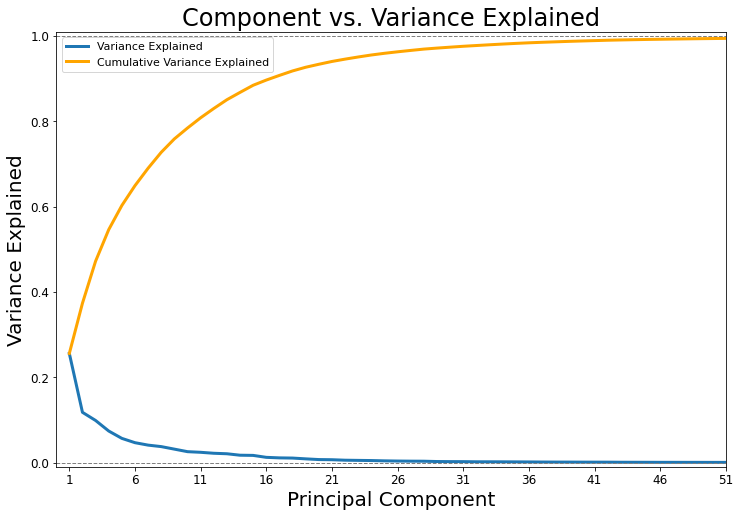

In [31]:
# Plot the variance explained (and cumulative variance explained).

# Pull the explained variance attribute.
var_exp = pca.explained_variance_ratio_
#print(f'Explained variance (first 50 components): {np.round(var_exp[:50],3)}')

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
#print(f'Cumulative explained variance (first 50 components): {np.round(cum_var_exp[:50],3)}')

# Set figure size.
plt.figure(figsize=(12,8))

# Plot the explained variance.
plt.plot(range(len(var_exp)), var_exp, lw=3, label = 'Variance Explained')

# Plot the cumulative explained variance.
plt.plot(range(len(var_exp)), cum_var_exp, lw=3, color = 'orange', label = 'Cumulative Variance Explained')

# Add horizontal lines at y=0 and y=1.
plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')

# Set the limits of the axes.
plt.xlim([-1,31])
plt.ylim([-0.01,1.01])

# Label the axes.
plt.ylabel('Variance Explained', fontsize=20)
plt.xlabel('Principal Component', fontsize=20)

# Make the tick labels bigger
plt.xticks(range(0, 51, 5), range(1, 52, 5), fontsize=12)
plt.yticks(fontsize=12)
    
# Add title and legend.
plt.title('Component vs. Variance Explained', fontsize=24)
plt.legend(fontsize=11);

Based on our graph above, we can observe that the top30 components are able to explain the 97.6% of the variance, top40 at 98.9% and all 50 at 99.4%.  
However, we will perform GridSearch to find the best components number to fit into our model.

In [36]:
# Create DataFrame and write data in
model_results = pd.DataFrame(columns=['model','best_params'])

# List of pipeline steps for each model
pipelist = [ 
    [('pca',PCA()),('logreg',LogisticRegression(solver='lbfgs', max_iter=5000))],
    [('pca',PCA()),('xgboost', XGBClassifier())]]

# Name each steps to include in out model
steps_titles = ['logreg', 'xgb',]

# Set the pipeline parameters
pipe_params = [
    # For logreg
    {'pca__n_components': [30,40,50],
     'logreg__C': [1,10,20]},
    # For xgb
    {'pca__n_components': [30,40,50],
    'xgboost__max_depth': [3, 4, 5, 6], #Depth of tree (higher value implies liekly overfit)
    'xgboost__gamma' : [ 0.0, 0.2 , 0.4], #Min loss reduction required for further partition
    'xgboost__learning_rate' : [0.15, 0.25, 0.35], #step size feature weight shrinkage
    'xgboost__use_label_encoder' : [False],
    'xgboost__eval_metric': ["auc"],
    "xgboost__objective" : ["binary:logistic"]}]

In [39]:
# Loop through our GridSearch and write into our table (gscv_results)
for i in range(len(steps_titles)):     
    pipe = Pipeline(steps=pipelist[i]) 
    gs = GridSearchCV(pipe, pipe_params[i], cv=3) 
    
    # Results for each model (dict)
    model_metric = {}

    gs.fit(Z_train, y_train)
    
    # Set each value into temporary dict
    model_metric['model'] = steps_titles[i]
    model_metric['best_params'] = gs.best_params_
    model_metric['train_score'] = round(gs.score(Z_train, y_train),4)
    model_metric['test_score'] = round(gs.score(Z_holdout, y_holdout),4)
    
    preds = gs.predict(Z_holdout)
    preds_proba = gs.predict_proba(Z_holdout)[:,1]
    #train_preds_proba = gs.predict_proba(Z_train)[:,1]
    
    #model_metric['Train ROC-AUC Score'] = metrics.roc_auc_score(y_train, train_preds_proba)
    model_metric['Test ROC-AUC Score'] = metrics.roc_auc_score(y_holdout, preds_proba)
    #model_metric['F1'] = metrics.f1_score(y_test, preds)
    #model_metric['Precision'] = metrics.precision_score(y_test, preds)
    #model_metric['Recall'] = metrics.recall_score(y_test, preds)
    #model_metric['Accuracy'] = metrics.accuracy_score(y_test, preds)
    
    model_results = model_results.append(model_metric, ignore_index=True)

In [41]:
#pd.set_option('display.max_colwidth', None)
#model_results

,model,best_params,Test ROC-AUC Score,test_score,train_score
0,logreg,"{'logreg__C': 1, 'pca__n_components': 30}",0.825832,0.9457,0.9459
1,xgb,"{'pca__n_components': 40, 'xgboost__eval_metric': 'auc', 'xgboost__gamma': 0.4, 'xgboost__learning_rate': 0.15, 'xgboost__max_depth': 3, 'xgboost__objective': 'binary:logistic', 'xgboost__use_label_encoder': False}",0.840012,0.9473,0.9501


Markdown table (in case):

| Models   | Best Params                                                                                                                                                                                                            | Test ROC-AUC Score | test_score | train_score |
|----------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------|------------|-------------|
| Logistic | {'logreg__C': 1, 'pca__n_components': 30}                                                                                                                                                                              | 0.825832           | 0.9457     | 0.9459      |
| XGBoost  | {'pca__n_components': 40, 'xgboost__eval_metric': 'auc', 'xgboost__gamma': 0.4, 'xgboost__learning_rate': 0.15, 'xgboost__max_depth': 3, 'xgboost__objective': 'binary:logistic', 'xgboost__use_label_encoder': False} | 0.840012           | 0.9473     | 0.9501      |

<u>**Polynomial + PCA Summary**</u>

Firstly, we expanded the features using polynomial features with degree of 2. This created 1000+ features in our feature set. 
Then we used PCA to try to reduce the dimensionality.  
As observed above, we can explain up to 99.4% of the variation in our data with 50 components at best.

During our modelling process, we tried multiple models (Logistic reg, AdaBoost, Gradient Boost, SVM, Random Forest, Extra Trees and XGBoost.

From the model summary table, noticed that the best 2 models were XGBoost classifier and logistic regression. They did perform well on our accuracy score and ROC-AUC score. However, the score is still lower than our best model (discussed below).

The ROC-AUC score that we prioritise and can be obtained from our procedure above only yielded 0.84 at best.

### Selection of Features by Correlation

(find the proper term)

## SMOTE

to resolve class imbalance ...

## Model Evaluation

|Classifier|Cutoff|PCA_components|Train ROC-AUC Score|Test ROC-AUC Score|F1|Precision|Recall|Accuracy|
|---|---|---|---|---|---|---|---|---|
||||||||||
||||||||||
|****|||||||||
|****|||||||||

# Cost-Benefit Analysis of Spraying

...

# Conclusions

insights/findings from evaluation & CBA